## Requirements

In [1]:

import os
from datetime import datetime

import pymysql
import pandas as pd
import numpy as np

import clickhouse_connect


In [2]:

August_1_2023 = '01/08/23'
August_1_2023 = datetime.strptime(August_1_2023, '%d/%m/%y')


## Users

In [3]:
query = """SELECT
  users.ID AS UserID,
  users.CreatedAt AS JoinDate,
  FirstOrder.FirstOrderAt AS ActivationDate
FROM
  users
  LEFT JOIN `vw_users_first_order` AS FirstOrder ON users.ID = FirstOrder.UserID"""


In [4]:
## Making database connection

HOST = os.environ.get('MYSQL_HOST')
USER = os.environ.get('MYSQL_USER')
PASSWORD = os.environ.get('MYSQL_PASSWORD')
conn = pymysql.connect(
    host=HOST,
    user=USER,
    password=PASSWORD,
    db='mydb',
    charset='utf8mb4',
    cursorclass=pymysql.cursors.DictCursor)


## Reading from database
try:
    with conn.cursor() as cursor:
        cursor.execute(query)
        rows = cursor.fetchall()
        users = pd.DataFrame(rows)
finally:
    conn.close()
    
print('Done Reading the Database!')
print("Shape of users:", users.shape)
del rows

Done Reading the Database!
Shape of users: (392825, 3)


### Active and Passive Users

In [5]:

active_users = users[users['ActivationDate'].notnull()]
passive_users = users[users['ActivationDate'].isnull()]

print("Shape of active users:", active_users.shape)
print("Shape of passive users:", passive_users.shape)
print('\n')

active_users = active_users[active_users['JoinDate']>=August_1_2023]
passive_users = passive_users[passive_users['JoinDate']>=August_1_2023]
active_users.reset_index(inplace=True, drop=True)
passive_users.reset_index(inplace=True, drop=True)

print("Shape of active users joined after August 1 2023:", active_users.shape)
print("Shape of passive users joined after August 1 2023:", passive_users.shape)

del users

Shape of active users: (14528, 3)
Shape of passive users: (378297, 3)


Shape of active users joined after August 1 2023: (5898, 3)
Shape of passive users joined after August 1 2023: (215500, 3)


In [6]:

active_users['Period'] = ((active_users['ActivationDate'] - active_users['JoinDate'])/pd.Timedelta(days=1).ceil('D')).round(decimals=0)
passive_users['Period'] = ((pd.Timestamp.today() - passive_users['JoinDate'])/pd.Timedelta(days=1).ceil('D')).round(decimals=0)
active_users.replace({'Period':0},1)
passive_users.replace({'Period':0},1)
active_users.head()


,UserID,JoinDate,ActivationDate,Period
0,171835,2023-08-01 04:17:45,2023-12-26 11:03:17,147.0
1,171872,2023-08-01 07:31:23,2023-08-10 15:06:41,9.0
2,171928,2023-08-01 09:25:38,2023-10-27 21:55:18,88.0
3,171948,2023-08-01 10:21:25,2024-05-24 16:53:42,297.0
4,171956,2023-08-01 10:38:00,2023-08-06 20:43:33,5.0


## ClickHouse Tables

In [7]:

# ClickHouse Database Settings
HOST = os.environ.get("CLICKHOUSE_HOST")
PORT = 8123
USER = os.environ.get("CLICKHOUSE_USERNAME")
PASSWORD = os.environ.get("CLICKHOUSE_PASSWORD")
DATABASE = os.environ["CLICKHOUSE_DATABASE"]


In [8]:

tables = ['advertisement_clicked','application_opened', 'application_updated', 'collection_clicked',
          'product_added_to_wishlist', 'product_clicked', 'product_image_download', 
          'product_list_filtered', 'product_list_viewed', 'product_shared', 'products_searched', 
          'product_video_download', 'product_video_play', 'product_viewed', 'promotion_clicked', 'tooltip_clicked']

event_names = ['AddClick', 'AppOpen', 'AppUpdate', 'CollectionClick',
               'ProductAddtoList',  'ProductClick', 'ProductImageDownload',
               'ProductListFilter', 'ProductListView', 'ProductShare', 'ProductSearch', 
               'ProductVideoDownload', 'ProductVideoPlay', 'ProductView', 'PromotionClick', 'TooltipClick']


In [9]:

active_events = pd.DataFrame(active_users['UserID'])
passive_events = pd.DataFrame(passive_users['UserID'])


In [10]:
## Making database connection

conn = clickhouse_connect.get_client(host=HOST, port=PORT, username=USER, 
                                         password=PASSWORD, secure=False)
for i in range(len(tables)):
    event = event_names[i]
    table = tables[i]
    query = """SELECT user_id AS UserID, context_session_id AS Session, MAX (timestamp) AS Time, COUNT(id) AS {} 
            FROM {} 
            WHERE UserID IS NOT NULL AND notEmpty(UserID) = 1 AND UserID <> ''
            AND Session IS NOT NULL
            GROUP BY UserID, Session;""".format(event, table)
    
    result = conn.query(query)
    rows = result.result_rows
    df = pd.DataFrame(rows, columns=['UserID','Session', 'Time', event])
    
    print(i, "-", event)
    # print("Shape of original dataframe:", df.shape)
    
    # # Cleaning the UserID column
    df = df[df['UserID'].str.isdecimal()]
    df['UserID'] = df['UserID'].astype('int32')
    df['Session'] = df['Session'].astype('int16')
    df[event] = df[event].astype('int16')
    
    # print("Shape of dataframe after removing rows with invalid UserIDs:", df.shape)
    
    # Checking missing values in each column
    # missing_values = df.isnull().sum()
    # print("Missing values in each column:")
    # print(missing_values)
    
    # event by active and passive users
    active_df = df[df['UserID'].isin(active_users['UserID'])]
    passive_df = df[df['UserID'].isin(passive_users['UserID'])]
    
    if i == 0:
        active_join = pd.merge(active_users, active_df, left_on=['UserID'], right_on=['UserID'])
        active_join = active_join[active_join['Time']<active_join['ActivationDate']][['UserID', 'Session', 'Time', 'Period', event]]    
        
        active_user_session = active_join[['UserID', 'Session', 'Time', 'Period']].copy()
        active_join.drop(['Time', 'Period'], axis=1, inplace=True)
        active_events = pd.merge(active_events, active_join, how='outer', left_on=['UserID'], right_on=['UserID'])
                
        passive_join = pd.merge(passive_users, passive_df, left_on=['UserID'], right_on=['UserID'])
        passive_join = passive_join[['UserID', 'Session', 'Time', 'Period', event]]        
        
        passive_user_session = passive_join[['UserID', 'Session', 'Time', 'Period']].copy()
        passive_join.drop(['Time', 'Period'], axis=1, inplace=True)
        passive_events = pd.merge(passive_events, passive_join, how='outer', left_on=['UserID'], right_on=['UserID'])       
                 
    else:
        active_join = pd.merge(active_users, active_df, left_on=['UserID'], right_on=['UserID'])
        active_join = active_join[active_join['Time']<active_join['ActivationDate']][['UserID', 'Session', 'Time', 'Period', event]]  
       
        active_user_session = pd.concat([active_user_session, active_join[['UserID', 'Session', 'Time', 'Period']]])
        active_join.drop(['Time', 'Period'], axis=1, inplace=True)
        active_events = pd.merge(active_events, active_join, how='outer', left_on=['UserID', 'Session'], right_on=['UserID', 'Session'])

        passive_join = pd.merge(passive_users, passive_df, left_on=['UserID'], right_on=['UserID'])
        passive_join = passive_join[['UserID', 'Session', 'Time', 'Period', event]]
        
        passive_user_session = pd.concat([passive_user_session, passive_join[['UserID', 'Session', 'Time', 'Period']]])
        passive_join.drop(['Time', 'Period'], axis=1, inplace=True)
        passive_events = pd.merge(passive_events, passive_join, how='outer', left_on=['UserID', 'Session'], right_on=['UserID', 'Session'])
    # print('\n')
conn.close()

active_user_session['Time'] = active_user_session['Time'].dt.date                 
passive_user_session['Time'] = passive_user_session['Time'].dt.date                        

print("Done!")      

0 - AddClick
1 - AppOpen
2 - AppUpdate
3 - CollectionClick
4 - ProductAddtoList
5 - ProductClick
6 - ProductImageDownload
7 - ProductListFilter
8 - ProductListView
9 - ProductShare
10 - ProductSearch
11 - ProductVideoDownload
12 - ProductVideoPlay
13 - ProductView
14 - PromotionClick
15 - TooltipClick
Done!


In [11]:
active_events.head()
# active_events.shape
# passive_events.head()
# passive_events.shape


,UserID,Session,AddClick,AppOpen,AppUpdate,CollectionClick,ProductAddtoList,ProductClick,ProductImageDownload,ProductListFilter,ProductListView,ProductShare,ProductSearch,ProductVideoDownload,ProductVideoPlay,ProductView,PromotionClick,TooltipClick
0,171835,-30907.0,NaN,2.0,NaN,NaN,NaN,1.0,NaN,3.0,13.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,171835,-25059.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,171835,-23845.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,171835,-22276.0,NaN,9.0,NaN,NaN,NaN,4.0,NaN,9.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,171835,-16175.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Adding UniqueEventINSession and TotalEventsInSession

In [12]:

active_events['UniqueEventINSession'] = active_events.loc[:,'AppOpen':'TooltipClick'].count(axis=1)
active_events['#EventsInSession'] = active_events.loc[:,'AppOpen':'TooltipClick'].sum(axis=1)
# active_events.head()

passive_events['UniqueEventINSession'] = passive_events.loc[:,'AppOpen':'TooltipClick'].count(axis=1)
passive_events['#EventsInSession'] = passive_events.loc[:,'AppOpen':'TooltipClick'].sum(axis=1)
# passive_events.head()


## Creating dataframe for logistic regression

In [13]:
dfa = active_events.groupby('UserID', as_index=False).agg(AddClick=('AddClick','sum'),
                                         AppOpen=('AppOpen','sum'), AppUpdate=('AppUpdate','sum'), 
                                         CollectionClick=('CollectionClick','sum'), ProductAddtoList=('ProductAddtoList','sum'),
                                         ProductClick=('ProductClick','sum'), ProductImageDownload=('ProductImageDownload','sum'),
                                         ProductListFilter=('ProductListFilter','sum'), ProductListView=('ProductListView','sum'),
                                         ProductShare=('ProductShare','sum'), ProductSearch=('ProductSearch','sum'),
                                         ProductVideoDownload=('ProductVideoDownload','sum'), ProductVideoPlay=('ProductVideoPlay','sum'),
                                         ProductView=('ProductView','sum'), PromotionClick=('PromotionClick','sum'),
                                         TooltipClick=('TooltipClick','sum'), UniqueEventINSession=('UniqueEventINSession','mean'),
                                         EventsInSession=('#EventsInSession','mean'))

dfp = passive_events.groupby('UserID', as_index=False).agg(AddClick=('AddClick','sum'),
                                         AppOpen=('AppOpen','sum'), AppUpdate=('AppUpdate','sum'), 
                                         CollectionClick=('CollectionClick','sum'), ProductAddtoList=('ProductAddtoList','sum'),
                                         ProductClick=('ProductClick','sum'), ProductImageDownload=('ProductImageDownload','sum'),
                                         ProductListFilter=('ProductListFilter','sum'), ProductListView=('ProductListView','sum'),
                                         ProductShare=('ProductShare','sum'), ProductSearch=('ProductSearch','sum'),
                                         ProductVideoDownload=('ProductVideoDownload','sum'), ProductVideoPlay=('ProductVideoPlay','sum'),
                                         ProductView=('ProductView','sum'), PromotionClick=('PromotionClick','sum'),
                                         TooltipClick=('TooltipClick','sum'), UniqueEventINSession=('UniqueEventINSession','mean'),
                                         EventsInSession=('#EventsInSession','mean'))



## Adding Active Days Column

In [14]:

g_active = active_user_session.groupby("UserID").agg( 
    Sessions=("Session", "nunique"),
    ActiveDays=("Time", "nunique"),
    ActivationPeriod=("Period", "min"))

dfa = pd.merge(left=dfa, right= g_active, on='UserID')


g_passive = passive_user_session.groupby("UserID").agg( 
    Sessions=("Session", "nunique"),
    ActiveDays=("Time", "nunique"),
    ActivationPeriod=("Period", "min"))

dfp = pd.merge(left=dfp, right= g_passive, on='UserID')



In [15]:

dfa.replace({'ActiveDays':0},1, inplace=True)
dfp.replace({'ActiveDays':0},1, inplace=True)

dfa.replace({'ActivationPeriod':0},1, inplace=True)
dfp.replace({'ActivationPeriod':0},1, inplace=True)


In [16]:

dfa['ActiveDaysRate'] = dfa['ActiveDays'] / dfa['ActivationPeriod']
dfa['SessionPerDay'] = dfa['Sessions'] / dfa['ActiveDays']
dfa.drop(['ActiveDays', 'ActivationPeriod'], axis=1,inplace=True)

dfp['ActiveDaysRate'] = dfp['ActiveDays'] / dfp['ActivationPeriod']
dfp['SessionPerDay'] = dfp['Sessions'] / dfp['ActiveDays']
dfp.drop(['ActiveDays', 'ActivationPeriod'], axis=1,inplace=True)


## Pickling the df dataframes

In [17]:

dfa.to_pickle("Activeve.pkl")
dfp.to_pickle("Passiveve.pkl")
print('finish')


finish


## Regression Model

In [18]:
# Import required packages

# Data packages
import pandas as pd
import numpy as np

# Machine Learning / Classification packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
dfa['Status'] = 1
dfp['Status'] = 0
dfpp = dfp.sample(dfa.shape[0], ignore_index=True)
df = pd.concat([dfa, dfpp])
df.shape

(11246, 23)

In [23]:
# Shuffling the dataframe

df = df.sample(frac=1).reset_index(drop=True)
df.head(2)


,UserID,AddClick,AppOpen,AppUpdate,CollectionClick,ProductAddtoList,ProductClick,ProductImageDownload,ProductListFilter,ProductListView,...,ProductVideoPlay,ProductView,PromotionClick,TooltipClick,UniqueEventINSession,EventsInSession,Sessions,ActiveDaysRate,SessionPerDay,Status
0,384178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.500000,0.500000,1,1.000000,1.000000,1
1,248627,0.0,4.0,4.0,0.0,0.0,0.0,0.0,7.0,14.0,...,0.0,253.0,0.0,0.0,1.444444,31.333333,8,0.033019,1.142857,0


In [24]:

y = df['Status'].copy()
X = df.iloc[:,1:-1].copy()
X.head(1)


,AddClick,AppOpen,AppUpdate,CollectionClick,ProductAddtoList,ProductClick,ProductImageDownload,ProductListFilter,ProductListView,ProductShare,...,ProductVideoDownload,ProductVideoPlay,ProductView,PromotionClick,TooltipClick,UniqueEventINSession,EventsInSession,Sessions,ActiveDaysRate,SessionPerDay
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.5,0.5,1,1.0,1.0


In [25]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [26]:
X.head()

,AddClick,AppOpen,AppUpdate,CollectionClick,ProductAddtoList,ProductClick,ProductImageDownload,ProductListFilter,ProductListView,ProductShare,...,ProductVideoDownload,ProductVideoPlay,ProductView,PromotionClick,TooltipClick,UniqueEventINSession,EventsInSession,Sessions,ActiveDaysRate,SessionPerDay
0,-0.110661,-0.427883,-0.538915,-0.341685,-0.275539,-0.482372,-0.302567,-0.343779,-0.514932,-0.169623,...,-0.158053,-0.223272,-0.462980,-0.376108,0.307372,-1.773104,-0.803683,-0.527739,1.060260,-0.671283
1,-0.110661,-0.399824,1.174219,-0.341685,-0.275539,-0.482372,-0.302567,-0.261844,-0.448616,-0.169623,...,-0.158053,-0.223272,-0.393131,-0.376108,-0.296314,-1.137007,-0.585104,-0.204668,-0.723469,-0.529388
2,-0.110661,-0.357736,-0.538915,-0.341685,-0.275539,-0.462482,-0.302567,-0.273549,-0.415459,-0.169623,...,-0.158053,-0.223272,-0.397824,-0.239118,-0.296314,-1.043464,-0.642998,-0.066209,-0.683427,-0.671283
3,-0.110661,-0.322662,-0.538915,-0.341685,-0.275539,-0.482372,-0.302567,-0.343779,-0.514932,0.042271,...,-0.158053,-0.223272,-0.462980,-0.376108,-0.296314,-1.436347,-0.777099,-0.435433,-0.743835,-0.174651
4,-0.110661,-0.385795,1.602502,-0.341685,-0.275539,-0.482372,-0.302567,-0.343779,-0.514932,-0.169623,...,-0.158053,-0.223272,-0.462980,-0.376108,-0.296314,-1.503699,-0.799429,-0.158515,-0.739017,-0.671283


In [27]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression()

In [28]:
y_pred = logreg.predict(X)



In [29]:
logreg.predict_proba(X)[:10]

array([[9.09099033e-03, 9.90909010e-01],
       [9.49224476e-01, 5.07755239e-02],
       [9.37722657e-01, 6.22773433e-02],
       [9.63621646e-01, 3.63783543e-02],
       [9.66136410e-01, 3.38635900e-02],
       [1.32604884e-04, 9.99867395e-01],
       [8.11786041e-01, 1.88213959e-01],
       [6.89637224e-01, 3.10362776e-01],
       [1.08605384e-02, 9.89139462e-01],
       [9.43386161e-01, 5.66138388e-02]])

In [30]:
coefficients = logreg.coef_[0]


<Axes: ylabel='Feature'>

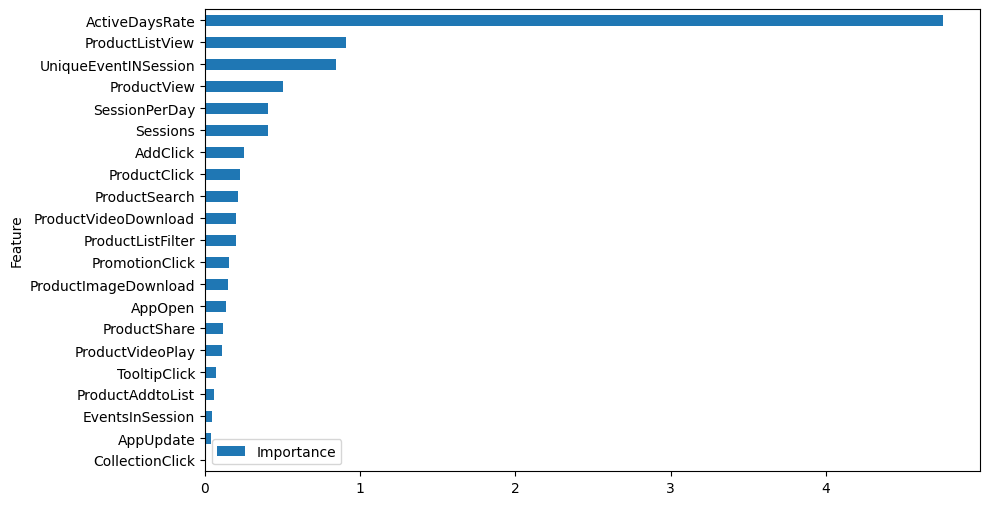

In [31]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [32]:
 logreg.score(X, y)

0.9153476791748177

In [33]:
 logreg.score(X_test, y_test)


0.9186666666666666

In [34]:
confusion_matrix(y, logreg.predict(X))

array([[5336,  287],
       [ 665, 4958]])

In [35]:
prediction = pd.DataFrame(scaler.fit_transform(dfp.iloc[:,1:-1]), columns=X.columns)
prediction.head()

,AddClick,AppOpen,AppUpdate,CollectionClick,ProductAddtoList,ProductClick,ProductImageDownload,ProductListFilter,ProductListView,ProductShare,...,ProductVideoDownload,ProductVideoPlay,ProductView,PromotionClick,TooltipClick,UniqueEventINSession,EventsInSession,Sessions,ActiveDaysRate,SessionPerDay
0,-0.083828,-0.098850,1.655960,-0.057885,-0.040633,-0.252606,-0.130463,-0.080722,-0.175920,0.821904,...,-0.085968,-0.157834,-0.291421,-0.072565,-0.288362,-0.827119,-0.690519,0.045615,-0.279334,-0.450817
1,-0.083828,-0.098850,1.282127,-0.057885,-0.125958,-0.125699,-0.130463,-0.059162,-0.101786,-0.143518,...,-0.085968,0.016507,-0.221625,-0.072565,0.895531,-0.575719,-0.589914,0.412447,-0.175634,-0.450817
2,-0.083828,1.200964,-0.587041,-0.057885,-0.040633,0.043510,1.511802,0.285800,0.581890,0.097838,...,-0.085968,-0.157834,-0.291421,0.164675,-0.288362,0.355188,-0.288910,-0.046093,-0.357109,1.043273
3,-0.083828,-0.050709,0.160626,-0.057885,-0.125958,0.085813,-0.067299,-0.080722,0.054718,-0.143518,...,-0.085968,-0.157834,0.021415,-0.072565,-0.288362,0.705873,0.007835,0.137323,-0.305259,0.445637
4,-0.083828,-0.211180,0.160626,-0.057885,-0.125958,-0.252606,-0.130463,-0.166962,-0.101786,-0.143518,...,-0.085968,-0.157834,-0.291421,-0.072565,-0.288362,-1.398233,-0.684569,-0.229509,-0.357109,-0.450817


In [36]:
pred = pd.DataFrame(logreg.predict_proba(prediction), columns=['Active','Passive']).round(decimals=2)


In [37]:
pred.sort_values(by=['Active'], inplace=True)
pred.head()

,Active,Passive
168268,0.0,1.0
186945,0.0,1.0
186943,0.0,1.0
168247,0.0,1.0
168241,0.0,1.0


In [55]:
act = pred[pred['Active']>=0.75]
act.shape[0]/pred.shape[0]


0.1039131050099066

In [43]:
act.shape[0] * 1/100

298.22

In [53]:
destination = 'file.csv'
act.to_csv(destination)
